The directories of Qian's experiment are listed as follows:

1/ wind + thermal perturbation run:
/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_qian_wthp

2/ wind + thermal +meltwater perturbation run:
/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_qian_wthmp

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import netCDF4 as nc

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import cmocean as cm

#From file of "Age at the Bottom of the Ocean"
from collections import OrderedDict
import cftime
import glob

#From file of "Cross-slope section"
# For gradient calculation (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
# Load metpy module to obtain cross section (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

#From file of "barotropic streamfunction"
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:46347' processes=8 threads=16, memory=144.00 GiB>

In [3]:
# Load database
session = cc.database.create_session()

# Start a Cosima cookbook database session

In [4]:
# From file of "Exploring the COSIMA Cookbook"
from cosima_cookbook import explore

dbx = explore.DatabaseExplorer(session=session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

## Experiment:	01deg_jra55v13_ryf9091

Description:	0.1 degree ACCESS-OM2 global model configuration under the RYF9091 Repeat Year Forcing strategy outlined by Stewart et al. (2020), https://doi.org/10.1016/j.ocemod.2019.101557. The configuration is based on that described in Kiss et al. (2020), https://doi.org/10.5194/gmd-13-401-2020, but with many improvements. Initial conditions are WOA13v2 potential temperature and practical salinity. Run with JRA55-do v1.3 RYF9091 forcing. Spin up starts from a nominal year of 1 Jan 1900 and runs to 31 Dec 2100.

Notes:	Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1969 and 1 Jan 2086 to 31 Dec 2100

Contact:	Andy Hogg <andy.hogg@anu.edu.au>

No. files:	12671

Created:	2020-06-11

In [5]:
# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00') - 273.15
salt_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')

# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_ryf = temp_ryf.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2099-12-31 00:00:00','2129-12-31 00:00:00'))
salt_ryf = salt_ryf.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2099-12-31 00:00:00','2129-12-31 00:00:00'))

# Select surface ocean:
temp_surface_ryf = temp_ryf.sel(st_ocean=0, method='nearest')
salt_surface_ryf = salt_ryf.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m_ryf = temp_ryf.sel(st_ocean=250, method='nearest')
salt_250m_ryf = salt_ryf.sel(st_ocean=250, method='nearest')

# Select slice at sea floor:
# Array that has the depth levels
temp_depth_array_ryf = temp_ryf * 0 + temp_ryf.st_ocean
salt_depth_array_ryf = salt_ryf * 0 + salt_ryf.st_ocean
# Get max depth of data (skipping nans)
temp_max_depth_ryf   = temp_depth_array_ryf.max(dim='st_ocean', skipna=True)
salt_max_depth_ryf   = salt_depth_array_ryf.max(dim='st_ocean', skipna=True)
# Select the temp using max_depth
# Bottom is where the depth level is larger/equal the max depth
temp_bottom_ryf = temp_ryf.where(temp_depth_array_ryf.st_ocean >= temp_max_depth_ryf)
temp_bottom_ryf = temp_bottom_ryf.sum(dim='st_ocean')
salt_bottom_ryf = salt_ryf.where(salt_depth_array_ryf.st_ocean >= salt_max_depth_ryf)
salt_bottom_ryf = salt_bottom_ryf.sum(dim='st_ocean')

# Weighted average with all depths
st_edges_ocean_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')
thickness_values_ryf = np.diff(st_edges_ocean_ryf)
thickness_ryf = xr.DataArray(data=thickness_values_ryf,dims=["st_ocean"],coords=dict(st_ocean=temp_ryf.st_ocean.values,),)
#for coords, st_ocean=var.st_ocean.values.
weights_st_ryf = thickness_ryf
temp_st_ryf = temp_ryf.weighted(weights_st_ryf).mean('st_ocean')
salt_st_ryf = salt_ryf.weighted(weights_st_ryf).mean('st_ocean')

In [6]:
# Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate Antarctic continental regions.
ht_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', session=session, frequency='static', n=1)
ht_ryf = ht_ryf.sel(yt_ocean = slice(lat_min, lat_max)) # Select latitude range
land_mask_ryf = ~ht_ryf.isnull()
shelf_mask_ryf = (land_mask_ryf.where(ht_ryf < 1000))

#Put temp and salt into the shelf mask
temp_shelf_ryf = temp_ryf*shelf_mask_ryf
salt_shelf_ryf = salt_ryf*shelf_mask_ryf

temp_surface_shelf_ryf = temp_surface_ryf*shelf_mask_ryf
temp_250m_shelf_ryf = temp_250m_ryf*shelf_mask_ryf
temp_bottom_shelf_ryf = temp_bottom_ryf*shelf_mask_ryf
temp_st_shelf_ryf = temp_st_ryf*shelf_mask_ryf
salt_surface_shelf_ryf = salt_surface_ryf*shelf_mask_ryf
salt_250m_shelf_ryf = salt_250m_ryf*shelf_mask_ryf
salt_bottom_shelf_ryf = salt_bottom_ryf*shelf_mask_ryf
salt_st_shelf_ryf = salt_st_ryf*shelf_mask_ryf

## Experiment:	01deg_jra55v13_ryf9091_qian_wthp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5), plus meltwater perturbation

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	410

Created:	2021-04-20

In [7]:
# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00') - 273.15
salt_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')

# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_wthp = temp_wthp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2099-12-31 00:00:00','2129-12-31 00:00:00'))
salt_wthp = salt_wthp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2099-12-31 00:00:00','2129-12-31 00:00:00'))

# Select surface ocean:
temp_surface_wthp = temp_wthp.sel(st_ocean=0, method='nearest')
salt_surface_wthp = salt_wthp.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m_wthp = temp_wthp.sel(st_ocean=250, method='nearest')
salt_250m_wthp = salt_wthp.sel(st_ocean=250, method='nearest')

# Select slice at sea floor:
# Array that has the depth levels
temp_depth_array_wthp = temp_wthp * 0 + temp_wthp.st_ocean
salt_depth_array_wthp = salt_wthp * 0 + salt_wthp.st_ocean
# Get max depth of data (skipping nans)
temp_max_depth_wthp   = temp_depth_array_wthp.max(dim='st_ocean', skipna=True)
salt_max_depth_wthp   = salt_depth_array_wthp.max(dim='st_ocean', skipna=True)
# Select the temp using max_depth
# Bottom is where the depth level is larger/equal the max depth
temp_bottom_wthp = temp_wthp.where(temp_depth_array_wthp.st_ocean >= temp_max_depth_wthp)
temp_bottom_wthp = temp_bottom_wthp.sum(dim='st_ocean')
salt_bottom_wthp = salt_wthp.where(salt_depth_array_wthp.st_ocean >= salt_max_depth_wthp)
salt_bottom_wthp = salt_bottom_wthp.sum(dim='st_ocean')

# Weighted average with all depths
st_edges_ocean_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')
thickness_values_wthp = np.diff(st_edges_ocean_wthp)
thickness_wthp = xr.DataArray(data=thickness_values_wthp,dims=["st_ocean"],coords=dict(st_ocean=temp_wthp.st_ocean.values,),)
#for coords, st_ocean=var.st_ocean.values.
weights_st_wthp = thickness_wthp
temp_st_wthp = temp_wthp.weighted(weights_st_wthp).mean('st_ocean')
salt_st_wthp = salt_wthp.weighted(weights_st_wthp).mean('st_ocean')

In [8]:
# Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate Antarctic continental regions.
ht_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='ht', session=session, frequency='static', n=1)
ht_wthp = ht_wthp.sel(yt_ocean = slice(lat_min, lat_max))
land_mask_wthp = ~ht_wthp.isnull()
shelf_mask_wthp = (land_mask_wthp.where(ht_wthp < 1000))

#Put temp and salt into the shelf mask
temp_shelf_wthp = temp_wthp*shelf_mask_wthp
salt_shelf_wthp = salt_wthp*shelf_mask_wthp

temp_surface_shelf_wthp = temp_surface_wthp*shelf_mask_wthp
temp_250m_shelf_wthp = temp_250m_wthp*shelf_mask_wthp
temp_bottom_shelf_wthp = temp_bottom_wthp*shelf_mask_wthp
temp_st_shelf_wthp = temp_st_wthp*shelf_mask_wthp
salt_surface_shelf_wthp = salt_surface_wthp*shelf_mask_wthp
salt_250m_shelf_wthp = salt_250m_wthp*shelf_mask_wthp
salt_bottom_shelf_wthp = salt_bottom_wthp*shelf_mask_wthp
salt_st_shelf_wthp = salt_st_wthp*shelf_mask_wthp

## Experiment:	01deg_jra55v13_ryf9091_qian_wthmp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5)

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	390

Created:	2021-04-20

In [9]:
# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00') - 273.15
salt_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')

# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_wthmp = temp_wthmp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2109-12-31 00:00:00','2129-12-31 00:00:00'))
salt_wthmp = salt_wthmp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2109-12-31 00:00:00','2129-12-31 00:00:00'))

# Select surface ocean:
temp_surface_wthmp = temp_wthmp.sel(st_ocean=0, method='nearest')
salt_surface_wthmp = salt_wthmp.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m_wthmp = temp_wthmp.sel(st_ocean=250, method='nearest')
salt_250m_wthmp = salt_wthmp.sel(st_ocean=250, method='nearest')

# Select slice at sea floor:
# Array that has the depth levels
temp_depth_array_wthmp = temp_wthmp * 0 + temp_wthmp.st_ocean
salt_depth_array_wthmp = salt_wthmp * 0 + salt_wthmp.st_ocean
# Get max depth of data (skipping nans)
temp_max_depth_wthmp   = temp_depth_array_wthmp.max(dim='st_ocean', skipna=True)
salt_max_depth_wthmp   = salt_depth_array_wthmp.max(dim='st_ocean', skipna=True)
# Select the temp using max_depth
# Bottom is where the depth level is larger/equal the max depth
temp_bottom_wthmp = temp_wthmp.where(temp_depth_array_wthmp.st_ocean >= temp_max_depth_wthmp)
temp_bottom_wthmp = temp_bottom_wthmp.sum(dim='st_ocean')
salt_bottom_wthmp = salt_wthmp.where(salt_depth_array_wthmp.st_ocean >= salt_max_depth_wthmp)
salt_bottom_wthmp = salt_bottom_wthmp.sum(dim='st_ocean')

# Weighted average with all depths
st_edges_ocean_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')
thickness_values_wthmp = np.diff(st_edges_ocean_wthmp)
thickness_wthmp = xr.DataArray(data=thickness_values_wthmp,dims=["st_ocean"],coords=dict(st_ocean=temp_wthmp.st_ocean.values,),)
#for coords, st_ocean=var.st_ocean.values.
weights_st_wthmp = thickness_wthmp
temp_st_wthmp = temp_wthmp.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_wthmp = salt_wthmp.weighted(weights_st_wthmp).mean('st_ocean')

In [10]:
#Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate Antarctic continental regions.
ht_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='ht', session=session, frequency='static', n=1)
ht_wthmp = ht_wthmp.sel(yt_ocean = slice(lat_min, lat_max))
land_mask_wthmp = ~ht_wthmp.isnull()
shelf_mask_wthmp = (land_mask_wthmp.where(ht_wthmp < 1000))

#Put temp and salt into the shelf mask
temp_shelf_wthmp = temp_wthmp*shelf_mask_wthmp
salt_shelf_wthmp = salt_wthmp*shelf_mask_wthmp

temp_surface_shelf_wthmp = temp_surface_wthmp*shelf_mask_wthmp
temp_250m_shelf_wthmp = temp_250m_wthmp*shelf_mask_wthmp
temp_bottom_shelf_wthmp = temp_bottom_wthmp*shelf_mask_wthmp
temp_st_shelf_wthmp = temp_st_wthmp*shelf_mask_wthmp
salt_surface_shelf_wthmp = salt_surface_wthmp*shelf_mask_wthmp
salt_250m_shelf_wthmp = salt_250m_wthmp*shelf_mask_wthmp
salt_bottom_shelf_wthmp = salt_bottom_wthmp*shelf_mask_wthmp
salt_st_shelf_wthmp = salt_st_wthmp*shelf_mask_wthmp

# Region Selection

Weddell Sea polynyas, Ross Sea polynya, Mertz Glacier polynya and Cape Darnley polynya are selected as four different shelf regions (surface, 250m and averaging over all depths) for comparison as a practice.

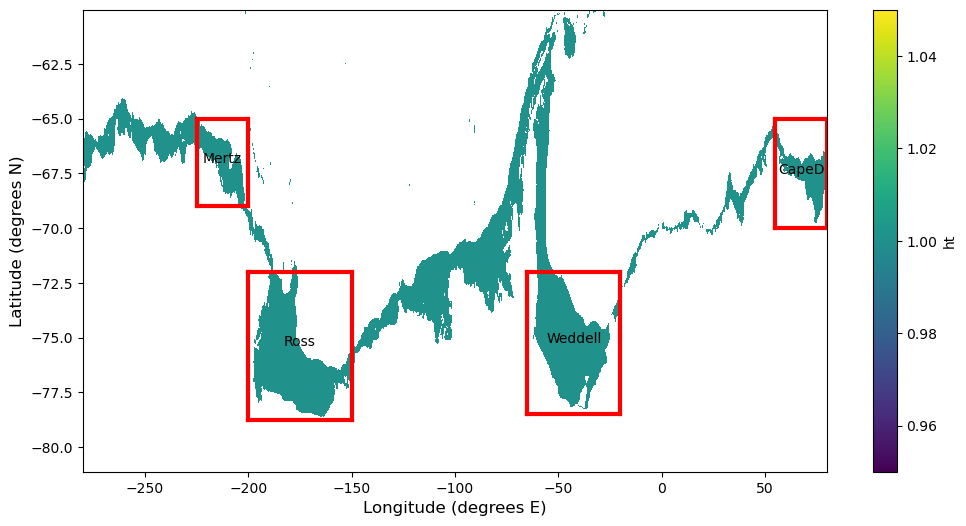

In [11]:
fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask_wthp.plot() 
#or shelf_mask_ryf.plot()
#or shelf_mask_wthmp.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)

# Weighted average over areas
area_t_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_t',  session=session, frequency='static', n=1)
area_t_ryf = area_t_ryf.sel(yt_ocean = slice(lat_min, lat_max))
area_t_ryf = area_t_ryf.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).

area_t_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='area_t',  session=session, frequency='static', n=1)
area_t_wthp = area_t_wthp.sel(yt_ocean = slice(lat_min, lat_max))
area_t_wthp = area_t_wthp.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).

area_t_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='area_t',  session=session, frequency='static', n=1)
area_t_wthmp = area_t_wthmp.sel(yt_ocean = slice(lat_min, lat_max))
area_t_wthmp = area_t_wthmp.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).


#Weddell Sea coastal polynyas shelf region
bottomleft_lon=-65
bottomleft_lat=-78.5
topright_lon=-20
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Weddell', horizontalalignment='center')

temp_shelf_ryf_Weddell = temp_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in ryf experiment
temp_st_shelf_ryf_Weddell = temp_st_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_surface_shelf_ryf_Weddell = temp_surface_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_250m_shelf_ryf_Weddell = temp_250m_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_bottom_shelf_ryf_Weddell = temp_bottom_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)

temp_shelf_wthp_Weddell = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthp experiment
temp_st_shelf_wthp_Weddell = temp_st_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_surface_shelf_wthp_Weddell = temp_surface_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_250m_shelf_wthp_Weddell = temp_250m_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_bottom_shelf_wthp_Weddell = temp_bottom_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)

temp_shelf_wthmp_Weddell = temp_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthmp experiment
temp_st_shelf_wthmp_Weddell = temp_st_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_surface_shelf_wthmp_Weddell = temp_surface_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_250m_shelf_wthmp_Weddell = temp_250m_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_bottom_shelf_wthmp_Weddell = temp_bottom_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)

salt_shelf_ryf_Weddell = salt_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in ryf experiment
salt_st_shelf_ryf_Weddell = salt_st_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_surface_shelf_ryf_Weddell = salt_surface_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_250m_shelf_ryf_Weddell = salt_250m_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_bottom_shelf_ryf_Weddell = salt_bottom_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)

salt_shelf_wthp_Weddell = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthp_Weddell = salt_st_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_surface_shelf_wthp_Weddell = salt_surface_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_250m_shelf_wthp_Weddell = salt_250m_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_bottom_shelf_wthp_Weddell = salt_bottom_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)

salt_shelf_wthmp_Weddell = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthmp experiment
salt_st_shelf_wthmp_Weddell = salt_st_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_surface_shelf_wthmp_Weddell = salt_surface_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_250m_shelf_wthmp_Weddell = salt_250m_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_bottom_shelf_wthmp_Weddell = salt_bottom_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)


#Ross Sea coastal polynya shelf region
bottomleft_lon=-200
bottomleft_lat=-78.75
topright_lon=-150
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Ross', horizontalalignment='center')

temp_shelf_ryf_Ross = temp_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in ryf experiment
temp_st_shelf_ryf_Ross = temp_st_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_surface_shelf_ryf_Ross = temp_surface_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_250m_shelf_ryf_Ross = temp_250m_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_bottom_shelf_ryf_Ross = temp_bottom_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)

temp_shelf_wthp_Ross = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthp experiment
temp_st_shelf_wthp_Ross = temp_st_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_surface_shelf_wthp_Ross = temp_surface_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_250m_shelf_wthp_Ross = temp_250m_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_bottom_shelf_wthp_Ross = temp_bottom_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)

temp_shelf_wthmp_Ross = temp_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthmp experiment
temp_st_shelf_wthmp_Ross = temp_st_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_surface_shelf_wthmp_Ross = temp_surface_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_250m_shelf_wthmp_Ross = temp_250m_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_bottom_shelf_wthmp_Ross = temp_bottom_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)

salt_shelf_ryf_Ross = salt_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in ryf experiment
salt_st_shelf_ryf_Ross = salt_st_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_surface_shelf_ryf_Ross = salt_surface_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_250m_shelf_ryf_Ross = salt_250m_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_bottom_shelf_ryf_Ross = salt_bottom_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)

salt_shelf_wthp_Ross = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthp_Ross = salt_st_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_surface_shelf_wthp_Ross = salt_surface_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_250m_shelf_wthp_Ross = salt_250m_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_bottom_shelf_wthp_Ross = salt_bottom_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)

salt_shelf_wthmp_Ross = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthmp experiment
salt_st_shelf_wthmp_Ross = salt_st_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_surface_shelf_wthmp_Ross = salt_surface_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_250m_shelf_wthmp_Ross = salt_250m_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_bottom_shelf_wthmp_Ross = salt_bottom_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)


#Cape Darnley polynya shelf region
bottomleft_lon=55
bottomleft_lat=-70
topright_lon=80
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'CapeD', horizontalalignment='center')

temp_shelf_ryf_CapeD = temp_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in ryf experiment
temp_st_shelf_ryf_CapeD = temp_st_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_surface_shelf_ryf_CapeD = temp_surface_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_250m_shelf_ryf_CapeD = temp_250m_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_bottom_shelf_ryf_CapeD = temp_bottom_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)

temp_shelf_wthp_CapeD = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthp experiment
temp_st_shelf_wthp_CapeD = temp_st_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_surface_shelf_wthp_CapeD = temp_surface_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_250m_shelf_wthp_CapeD = temp_250m_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_bottom_shelf_wthp_CapeD = temp_bottom_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)

temp_shelf_wthmp_CapeD = temp_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthmp experiment
temp_st_shelf_wthmp_CapeD = temp_st_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_surface_shelf_wthmp_CapeD = temp_surface_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_250m_shelf_wthmp_CapeD = temp_250m_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_bottom_shelf_wthmp_CapeD = temp_bottom_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)

salt_shelf_ryf_CapeD = salt_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in ryf experiment
salt_st_shelf_ryf_CapeD = salt_st_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_surface_shelf_ryf_CapeD = salt_surface_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_250m_shelf_ryf_CapeD = salt_250m_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_bottom_shelf_ryf_CapeD = salt_bottom_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)

salt_shelf_wthp_CapeD = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthp_CapeD = salt_st_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_surface_shelf_wthp_CapeD = salt_surface_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_250m_shelf_wthp_CapeD = salt_250m_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_bottom_shelf_wthp_CapeD = salt_bottom_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)

salt_shelf_wthmp_CapeD = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthmp_CapeD = salt_st_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_surface_shelf_wthmp_CapeD = salt_surface_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_250m_shelf_wthmp_CapeD = salt_250m_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_bottom_shelf_wthmp_CapeD = salt_bottom_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)


#Mertz Glacier Polynya shelf region
bottomleft_lon=-225
bottomleft_lat=-69
topright_lon=-200
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Mertz', horizontalalignment='center')

temp_shelf_ryf_Mertz = temp_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in ryf experiment
temp_st_shelf_ryf_Mertz = temp_st_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_surface_shelf_ryf_Mertz = temp_surface_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_250m_shelf_ryf_Mertz = temp_250m_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
temp_bottom_shelf_ryf_Mertz = temp_bottom_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)

temp_shelf_wthp_Mertz = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthp experiment
temp_st_shelf_wthp_Mertz = temp_st_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_surface_shelf_wthp_Mertz = temp_surface_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_250m_shelf_wthp_Mertz = temp_250m_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
temp_bottom_shelf_wthp_Mertz = temp_bottom_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)

temp_shelf_wthmp_Mertz = temp_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthmp experiment
temp_st_shelf_wthmp_Mertz = temp_st_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_surface_shelf_wthmp_Mertz = temp_surface_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_250m_shelf_wthmp_Mertz = temp_250m_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
temp_bottom_shelf_wthmp_Mertz = temp_bottom_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)

salt_shelf_ryf_Mertz = salt_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in ryf experiment
salt_st_shelf_ryf_Mertz = salt_st_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_surface_shelf_ryf_Mertz = salt_surface_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_250m_shelf_ryf_Mertz = salt_250m_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)
salt_bottom_shelf_ryf_Mertz = salt_bottom_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_ryf)

salt_shelf_wthp_Mertz = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthp_Mertz = salt_st_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_surface_shelf_wthp_Mertz = salt_surface_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_250m_shelf_wthp_Mertz = salt_250m_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)
salt_bottom_shelf_wthp_Mertz = salt_bottom_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthp)

salt_shelf_wthmp_Mertz = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthmp experiment
salt_st_shelf_wthmp_Mertz = salt_st_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_surface_shelf_wthmp_Mertz = salt_surface_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_250m_shelf_wthmp_Mertz = salt_250m_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)
salt_bottom_shelf_wthmp_Mertz = salt_bottom_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_wthmp)

In [12]:
#Create time series for different regions by averaging over lon-lat (359 months)
temp_st_shelf_ryf_Weddell_mean = temp_st_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthp_Weddell_mean = temp_st_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthmp_Weddell_mean = temp_st_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_ryf_Weddell_mean = salt_st_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthp_Weddell_mean = salt_st_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthmp_Weddell_mean = salt_st_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_ryf_Ross_mean = temp_st_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthp_Ross_mean = temp_st_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthmp_Ross_mean = temp_st_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_ryf_Ross_mean = salt_st_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthp_Ross_mean = salt_st_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthmp_Ross_mean = salt_st_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_ryf_CapeD_mean = temp_st_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthp_CapeD_mean = temp_st_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthmp_CapeD_mean = temp_st_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_ryf_CapeD_mean = salt_st_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthp_CapeD_mean = salt_st_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthmp_CapeD_mean = salt_st_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_ryf_Mertz_mean = temp_st_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthp_Mertz_mean = temp_st_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthmp_Mertz_mean = temp_st_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_ryf_Mertz_mean = salt_st_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthp_Mertz_mean = salt_st_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthmp_Mertz_mean = salt_st_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))

temp_surface_shelf_ryf_Weddell_mean = temp_surface_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthp_Weddell_mean = temp_surface_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthmp_Weddell_mean = temp_surface_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_ryf_Weddell_mean = salt_surface_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthp_Weddell_mean = salt_surface_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthmp_Weddell_mean = salt_surface_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_ryf_Ross_mean = temp_surface_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthp_Ross_mean = temp_surface_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthmp_Ross_mean = temp_surface_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_ryf_Ross_mean = salt_surface_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthp_Ross_mean = salt_surface_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthmp_Ross_mean = salt_surface_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_ryf_CapeD_mean = temp_surface_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthp_CapeD_mean = temp_surface_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthmp_CapeD_mean = temp_surface_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_ryf_CapeD_mean = salt_surface_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthp_CapeD_mean = salt_surface_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthmp_CapeD_mean = salt_surface_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_ryf_Mertz_mean = temp_surface_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthp_Mertz_mean = temp_surface_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthmp_Mertz_mean = temp_surface_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_ryf_Mertz_mean = salt_surface_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthp_Mertz_mean = salt_surface_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthmp_Mertz_mean = salt_surface_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))

temp_250m_shelf_ryf_Weddell_mean = temp_250m_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthp_Weddell_mean = temp_250m_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthmp_Weddell_mean = temp_250m_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_ryf_Weddell_mean = salt_250m_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthp_Weddell_mean = salt_250m_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthmp_Weddell_mean = salt_250m_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_ryf_Ross_mean = temp_250m_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthp_Ross_mean = temp_250m_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthmp_Ross_mean = temp_250m_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_ryf_Ross_mean = salt_250m_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthp_Ross_mean = salt_250m_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthmp_Ross_mean = salt_250m_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_ryf_CapeD_mean = temp_250m_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthp_CapeD_mean = temp_250m_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthmp_CapeD_mean = temp_250m_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_ryf_CapeD_mean = salt_250m_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthp_CapeD_mean = salt_250m_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthmp_CapeD_mean = salt_250m_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_ryf_Mertz_mean = temp_250m_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthp_Mertz_mean = temp_250m_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthmp_Mertz_mean = temp_250m_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_ryf_Mertz_mean = salt_250m_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthp_Mertz_mean = salt_250m_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthmp_Mertz_mean = salt_250m_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))

temp_bottom_shelf_ryf_Weddell_mean = temp_bottom_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthp_Weddell_mean = temp_bottom_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthmp_Weddell_mean = temp_bottom_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_ryf_Weddell_mean = salt_bottom_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthp_Weddell_mean = salt_bottom_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthmp_Weddell_mean = salt_bottom_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_ryf_Ross_mean = temp_bottom_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthp_Ross_mean = temp_bottom_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthmp_Ross_mean = temp_bottom_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_ryf_Ross_mean = salt_bottom_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthp_Ross_mean = salt_bottom_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthmp_Ross_mean = salt_bottom_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_ryf_CapeD_mean = temp_bottom_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthp_CapeD_mean = temp_bottom_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthmp_CapeD_mean = temp_bottom_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_ryf_CapeD_mean = salt_bottom_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthp_CapeD_mean = salt_bottom_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthmp_CapeD_mean = salt_bottom_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_ryf_Mertz_mean = temp_bottom_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthp_Mertz_mean = temp_bottom_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthmp_Mertz_mean = temp_bottom_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_ryf_Mertz_mean = salt_bottom_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthp_Mertz_mean = salt_bottom_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthmp_Mertz_mean = salt_bottom_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))

#Example
temp_st_shelf_ryf_Weddell_mean

<xarray.DataArray (time: 360)>
dask.array<truediv, shape=(360,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2100-01-16 12:00:00 ... 2129-12-16 12:00:00

In [13]:
#Create annual average time series for different regions (30 yrs)
temp_st_shelf_ryf_Weddell_mean_annual = temp_st_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Weddell_mean_annual = temp_st_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Weddell_mean_annual = temp_st_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Weddell_mean_annual = salt_st_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Weddell_mean_annual = salt_st_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Weddell_mean_annual = salt_st_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_Ross_mean_annual = temp_st_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Ross_mean_annual = temp_st_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Ross_mean_annual = temp_st_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Ross_mean_annual = salt_st_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Ross_mean_annual = salt_st_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Ross_mean_annual = salt_st_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_CapeD_mean_annual = temp_st_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_CapeD_mean_annual = temp_st_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_CapeD_mean_annual = temp_st_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_CapeD_mean_annual = salt_st_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_CapeD_mean_annual = salt_st_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_CapeD_mean_annual = salt_st_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_Mertz_mean_annual = temp_st_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Mertz_mean_annual = temp_st_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Mertz_mean_annual = temp_st_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Mertz_mean_annual = salt_st_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Mertz_mean_annual = salt_st_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Mertz_mean_annual = salt_st_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')

temp_surface_shelf_ryf_Weddell_mean_annual = temp_surface_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Weddell_mean_annual = temp_surface_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Weddell_mean_annual = temp_surface_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Weddell_mean_annual = salt_surface_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Weddell_mean_annual = salt_surface_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Weddell_mean_annual = salt_surface_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_Ross_mean_annual = temp_surface_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Ross_mean_annual = temp_surface_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Ross_mean_annual = temp_surface_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Ross_mean_annual = salt_surface_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Ross_mean_annual = salt_surface_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Ross_mean_annual = salt_surface_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_CapeD_mean_annual = temp_surface_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_CapeD_mean_annual = temp_surface_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_CapeD_mean_annual = temp_surface_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_CapeD_mean_annual = salt_surface_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_CapeD_mean_annual = salt_surface_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_CapeD_mean_annual = salt_surface_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_Mertz_mean_annual = temp_surface_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Mertz_mean_annual = temp_surface_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Mertz_mean_annual = temp_surface_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Mertz_mean_annual = salt_surface_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Mertz_mean_annual = salt_surface_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Mertz_mean_annual = salt_surface_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')

temp_250m_shelf_ryf_Weddell_mean_annual = temp_250m_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Weddell_mean_annual = temp_250m_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Weddell_mean_annual = temp_250m_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Weddell_mean_annual = salt_250m_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Weddell_mean_annual = salt_250m_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Weddell_mean_annual = salt_250m_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_Ross_mean_annual = temp_250m_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Ross_mean_annual = temp_250m_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Ross_mean_annual = temp_250m_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Ross_mean_annual = salt_250m_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Ross_mean_annual = salt_250m_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Ross_mean_annual = salt_250m_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_CapeD_mean_annual = temp_250m_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_CapeD_mean_annual = temp_250m_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_CapeD_mean_annual = temp_250m_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_CapeD_mean_annual = salt_250m_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_CapeD_mean_annual = salt_250m_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_CapeD_mean_annual = salt_250m_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_Mertz_mean_annual = temp_250m_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Mertz_mean_annual = temp_250m_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Mertz_mean_annual = temp_250m_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Mertz_mean_annual = salt_250m_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Mertz_mean_annual = salt_250m_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Mertz_mean_annual = salt_250m_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')

temp_bottom_shelf_ryf_Weddell_mean_annual = temp_bottom_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Weddell_mean_annual = temp_bottom_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Weddell_mean_annual = temp_bottom_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Weddell_mean_annual = salt_bottom_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Weddell_mean_annual = salt_bottom_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Weddell_mean_annual = salt_bottom_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_Ross_mean_annual = temp_bottom_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Ross_mean_annual = temp_bottom_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Ross_mean_annual = temp_bottom_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Ross_mean_annual = salt_bottom_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Ross_mean_annual = salt_bottom_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Ross_mean_annual = salt_bottom_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_CapeD_mean_annual = temp_bottom_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_CapeD_mean_annual = temp_bottom_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_CapeD_mean_annual = temp_bottom_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_CapeD_mean_annual = salt_bottom_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_CapeD_mean_annual = salt_bottom_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_CapeD_mean_annual = salt_bottom_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_Mertz_mean_annual = temp_bottom_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Mertz_mean_annual = temp_bottom_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Mertz_mean_annual = temp_bottom_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Mertz_mean_annual = salt_bottom_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Mertz_mean_annual = salt_bottom_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Mertz_mean_annual = salt_bottom_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')

#Example
temp_st_shelf_ryf_Weddell_mean_annual

<xarray.DataArray (year: 30)>
dask.array<stack, shape=(30,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2100 2101 2102 2103 2104 ... 2125 2126 2127 2128 2129

In [14]:
#Now create a monthly climatology for 1950-1980 period
temp_st_shelf_ryf_Weddell_clim = temp_st_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthp_Weddell_clim = temp_st_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthmp_Weddell_clim = temp_st_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_ryf_Weddell_clim = salt_st_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthp_Weddell_clim = salt_st_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthmp_Weddell_clim = salt_st_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')

temp_surface_shelf_ryf_Weddell_clim = temp_surface_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthp_Weddell_clim = temp_surface_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthmp_Weddell_clim = temp_surface_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_ryf_Weddell_clim = salt_surface_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthp_Weddell_clim = salt_surface_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthmp_Weddell_clim = salt_surface_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')

temp_250m_shelf_ryf_Weddell_clim = temp_250m_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthp_Weddell_clim = temp_250m_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthmp_Weddell_clim = temp_250m_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_ryf_Weddell_clim = salt_250m_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthp_Weddell_clim = salt_250m_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthmp_Weddell_clim = salt_250m_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')

temp_bottom_shelf_ryf_Weddell_clim = temp_bottom_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthp_Weddell_clim = temp_bottom_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthmp_Weddell_clim = temp_bottom_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_ryf_Weddell_clim = salt_bottom_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthp_Weddell_clim = salt_bottom_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthmp_Weddell_clim = salt_bottom_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')

#Example
temp_st_shelf_ryf_Weddell_clim

#Plot all 12 climatological months as an example
#temp_st_shelf_ryf_Weddell_clim.plot(col='month',col_wrap=3)

<xarray.DataArray (month: 12)>
dask.array<stack, shape=(12,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [15]:
#Calculate monthly anomalies from the climatology calculated above
temp_st_shelf_ryf_Weddell_anom = (temp_st_shelf_ryf_Weddell_mean.groupby('time.month') - temp_st_shelf_ryf_Weddell_clim)
temp_st_shelf_wthp_Weddell_anom = (temp_st_shelf_wthp_Weddell_mean.groupby('time.month') - temp_st_shelf_wthp_Weddell_clim)
temp_st_shelf_wthmp_Weddell_anom = (temp_st_shelf_wthmp_Weddell_mean.groupby('time.month') - temp_st_shelf_wthmp_Weddell_clim)
salt_st_shelf_ryf_Weddell_anom = (salt_st_shelf_ryf_Weddell_mean.groupby('time.month') - salt_st_shelf_ryf_Weddell_clim)
salt_st_shelf_wthp_Weddell_anom = (salt_st_shelf_wthp_Weddell_mean.groupby('time.month') - salt_st_shelf_wthp_Weddell_clim)
salt_st_shelf_wthmp_Weddell_anom = (salt_st_shelf_wthmp_Weddell_mean.groupby('time.month') - salt_st_shelf_wthmp_Weddell_clim)

temp_surface_shelf_ryf_Weddell_anom = (temp_surface_shelf_ryf_Weddell_mean.groupby('time.month') - temp_surface_shelf_ryf_Weddell_clim)
temp_surface_shelf_wthp_Weddell_anom = (temp_surface_shelf_wthp_Weddell_mean.groupby('time.month') - temp_surface_shelf_wthp_Weddell_clim)
temp_surface_shelf_wthmp_Weddell_anom = (temp_surface_shelf_wthmp_Weddell_mean.groupby('time.month') - temp_surface_shelf_wthmp_Weddell_clim)
salt_surface_shelf_ryf_Weddell_anom = (salt_surface_shelf_ryf_Weddell_mean.groupby('time.month') - salt_surface_shelf_ryf_Weddell_clim)
salt_surface_shelf_wthp_Weddell_anom = (salt_surface_shelf_wthp_Weddell_mean.groupby('time.month') - salt_surface_shelf_wthp_Weddell_clim)
salt_surface_shelf_wthmp_Weddell_anom = (salt_surface_shelf_wthmp_Weddell_mean.groupby('time.month') - salt_surface_shelf_wthmp_Weddell_clim)

temp_250m_shelf_ryf_Weddell_anom = (temp_250m_shelf_ryf_Weddell_mean.groupby('time.month') - temp_250m_shelf_ryf_Weddell_clim)
temp_250m_shelf_wthp_Weddell_anom = (temp_250m_shelf_wthp_Weddell_mean.groupby('time.month') - temp_250m_shelf_wthp_Weddell_clim)
temp_250m_shelf_wthmp_Weddell_anom = (temp_250m_shelf_wthmp_Weddell_mean.groupby('time.month') - temp_250m_shelf_wthmp_Weddell_clim)
salt_250m_shelf_ryf_Weddell_anom = (salt_250m_shelf_ryf_Weddell_mean.groupby('time.month') - salt_250m_shelf_ryf_Weddell_clim)
salt_250m_shelf_wthp_Weddell_anom = (salt_250m_shelf_wthp_Weddell_mean.groupby('time.month') - salt_250m_shelf_wthp_Weddell_clim)
salt_250m_shelf_wthmp_Weddell_anom = (salt_250m_shelf_wthmp_Weddell_mean.groupby('time.month') - salt_250m_shelf_wthmp_Weddell_clim)

temp_bottom_shelf_ryf_Weddell_anom = (temp_bottom_shelf_ryf_Weddell_mean.groupby('time.month') - temp_bottom_shelf_ryf_Weddell_clim)
temp_bottom_shelf_wthp_Weddell_anom = (temp_bottom_shelf_wthp_Weddell_mean.groupby('time.month') - temp_bottom_shelf_wthp_Weddell_clim)
temp_bottom_shelf_wthmp_Weddell_anom = (temp_bottom_shelf_wthmp_Weddell_mean.groupby('time.month') - temp_bottom_shelf_wthmp_Weddell_clim)
salt_bottom_shelf_ryf_Weddell_anom = (salt_bottom_shelf_ryf_Weddell_mean.groupby('time.month') - salt_bottom_shelf_ryf_Weddell_clim)
salt_bottom_shelf_wthp_Weddell_anom = (salt_bottom_shelf_wthp_Weddell_mean.groupby('time.month') - salt_bottom_shelf_wthp_Weddell_clim)
salt_bottom_shelf_wthmp_Weddell_anom = (salt_bottom_shelf_wthmp_Weddell_mean.groupby('time.month') - salt_bottom_shelf_wthmp_Weddell_clim)

#Example
temp_st_shelf_ryf_Weddell_anom

<xarray.DataArray (time: 360)>
dask.array<getitem, shape=(360,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2100-01-16 12:00:00 ... 2129-12-16 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [16]:
#Create annual anomaly time series for different regions (30 yrs)
temp_st_shelf_ryf_Weddell_anom_annual = temp_st_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Weddell_anom_annual = temp_st_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Weddell_anom_annual = temp_st_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Weddell_anom_annual = salt_st_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Weddell_anom_annual = salt_st_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Weddell_anom_annual = salt_st_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')

temp_surface_shelf_ryf_Weddell_anom_annual = temp_surface_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Weddell_anom_annual = temp_surface_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Weddell_anom_annual = temp_surface_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Weddell_anom_annual = salt_surface_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Weddell_anom_annual = salt_surface_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Weddell_anom_annual = salt_surface_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')

temp_250m_shelf_ryf_Weddell_anom_annual = temp_250m_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Weddell_anom_annual = temp_250m_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Weddell_anom_annual = temp_250m_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Weddell_anom_annual = salt_250m_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Weddell_anom_annual = salt_250m_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Weddell_anom_annual = salt_250m_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')

temp_bottom_shelf_ryf_Weddell_anom_annual = temp_bottom_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Weddell_anom_annual = temp_bottom_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Weddell_anom_annual = temp_bottom_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Weddell_anom_annual = salt_bottom_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Weddell_anom_annual = salt_bottom_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Weddell_anom_annual = salt_bottom_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')

#Example
temp_st_shelf_ryf_Weddell_anom_annual

<xarray.DataArray (year: 30)>
dask.array<stack, shape=(30,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2100 2101 2102 2103 2104 ... 2125 2126 2127 2128 2129

## Weddell Sea coastal polynyas shelf region

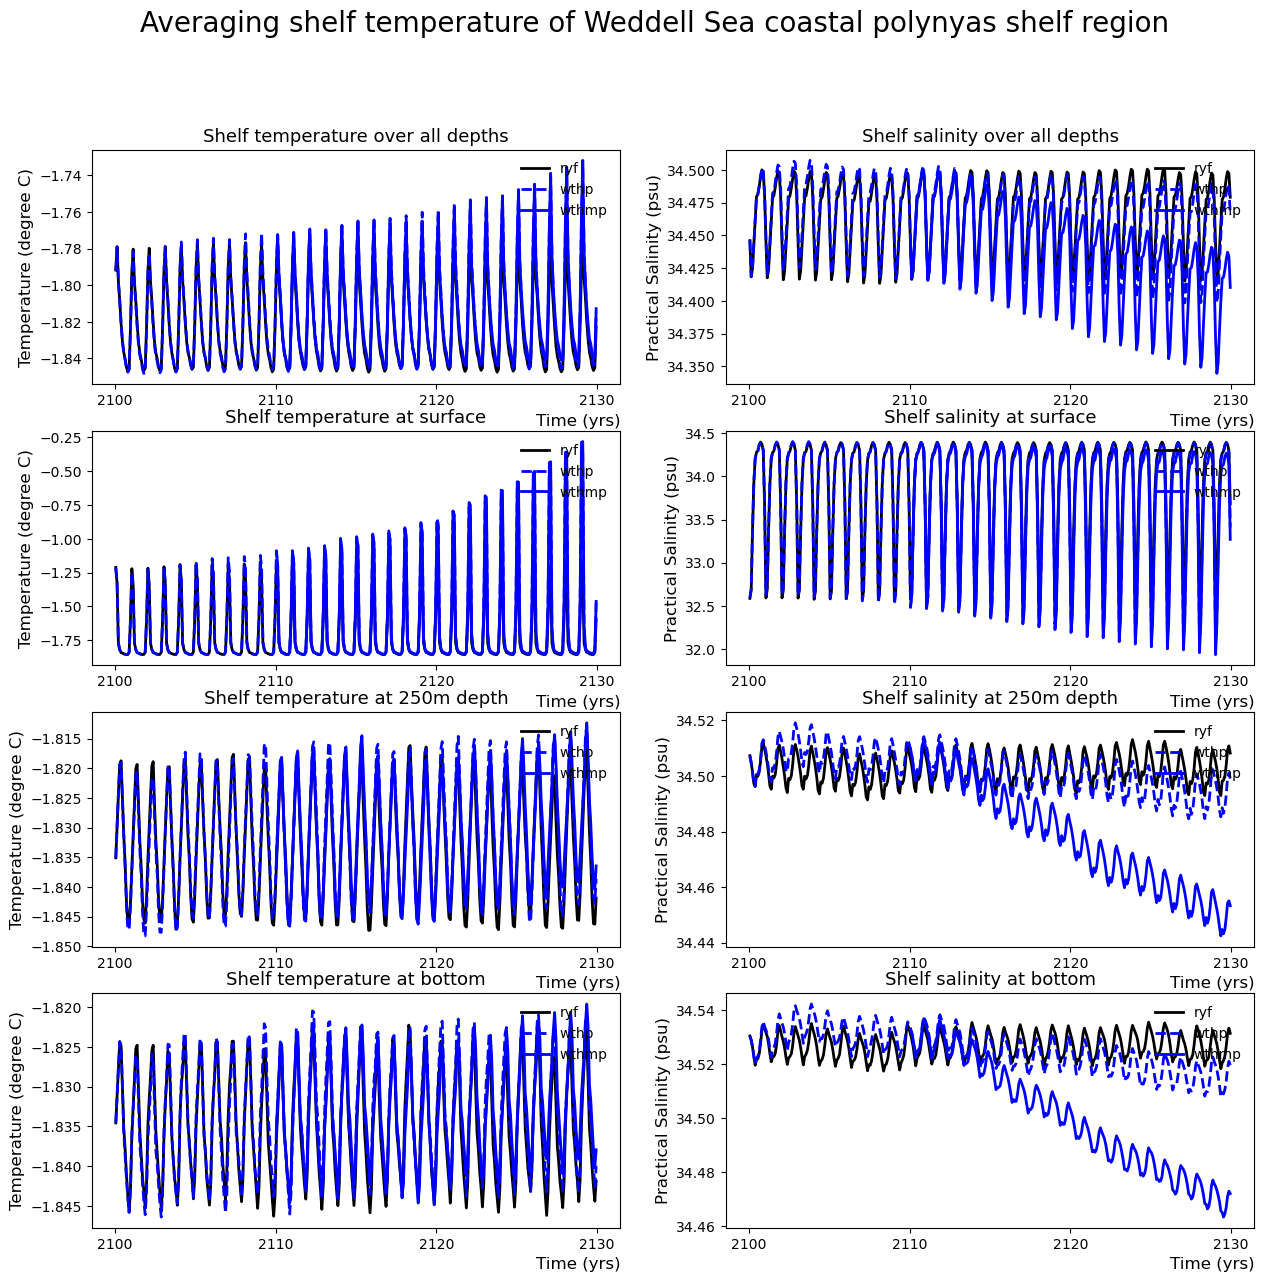

In [25]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature of Weddell Sea coastal polynyas shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

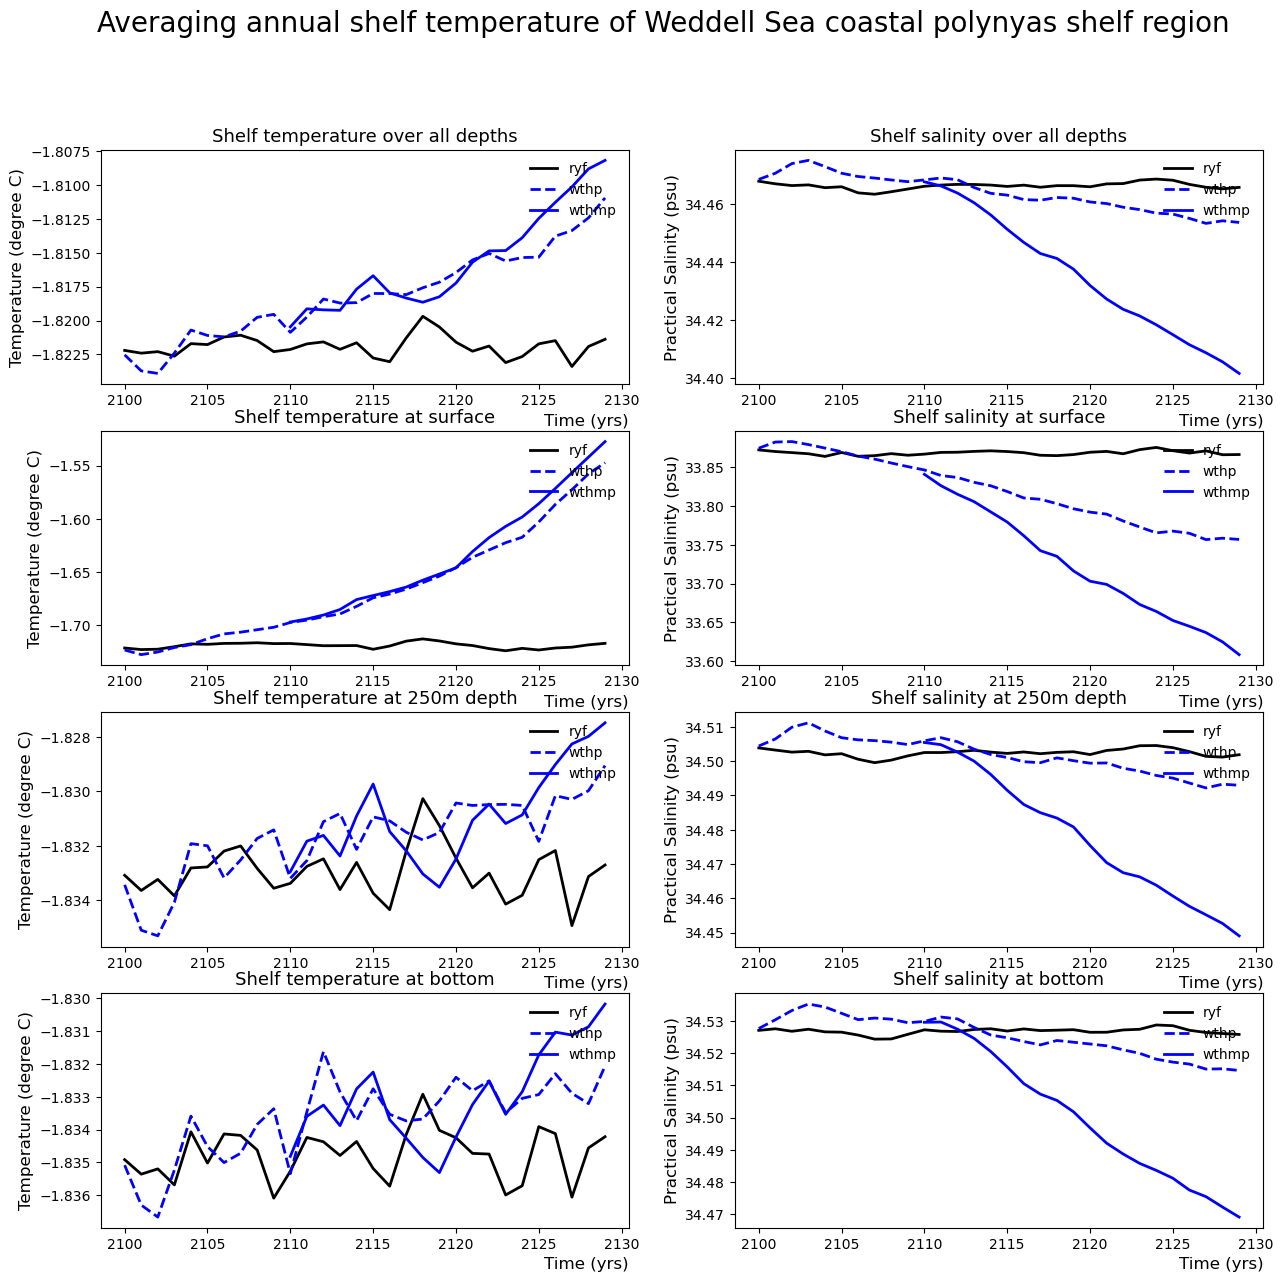

In [26]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature of Weddell Sea coastal polynyas shelf region', fontsize=20)

#Plotting annual mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

For Weddell Sea region

T:
Wind, thermal and humidity perturbation experiment compared to the control ryf experiment shows a consistant warming trend averaging over all depth and surface temperature and a slightly warming at 250m depth and bottom with some fluctations.

Wind, thermal, humidity and meltwater perturbation experiment compared to the wind, thermal and humidity perturbation experiment shows little changes for averaging over all depth and surface temperature at the beginning but slightly cooling in the last 10 yrs. The temp at 250m depth and bottom shows large fluctations.

S:
Wind, thermal and humidity perturbation experiment compared to the control ryf experiment shows a densing signal at the beginning and consistant freshing trend later.

Wind, thermal, humidity and meltwater perturbation experiment compared to the wind, thermal and humidity perturbation experiment shows consistant freshing trend.

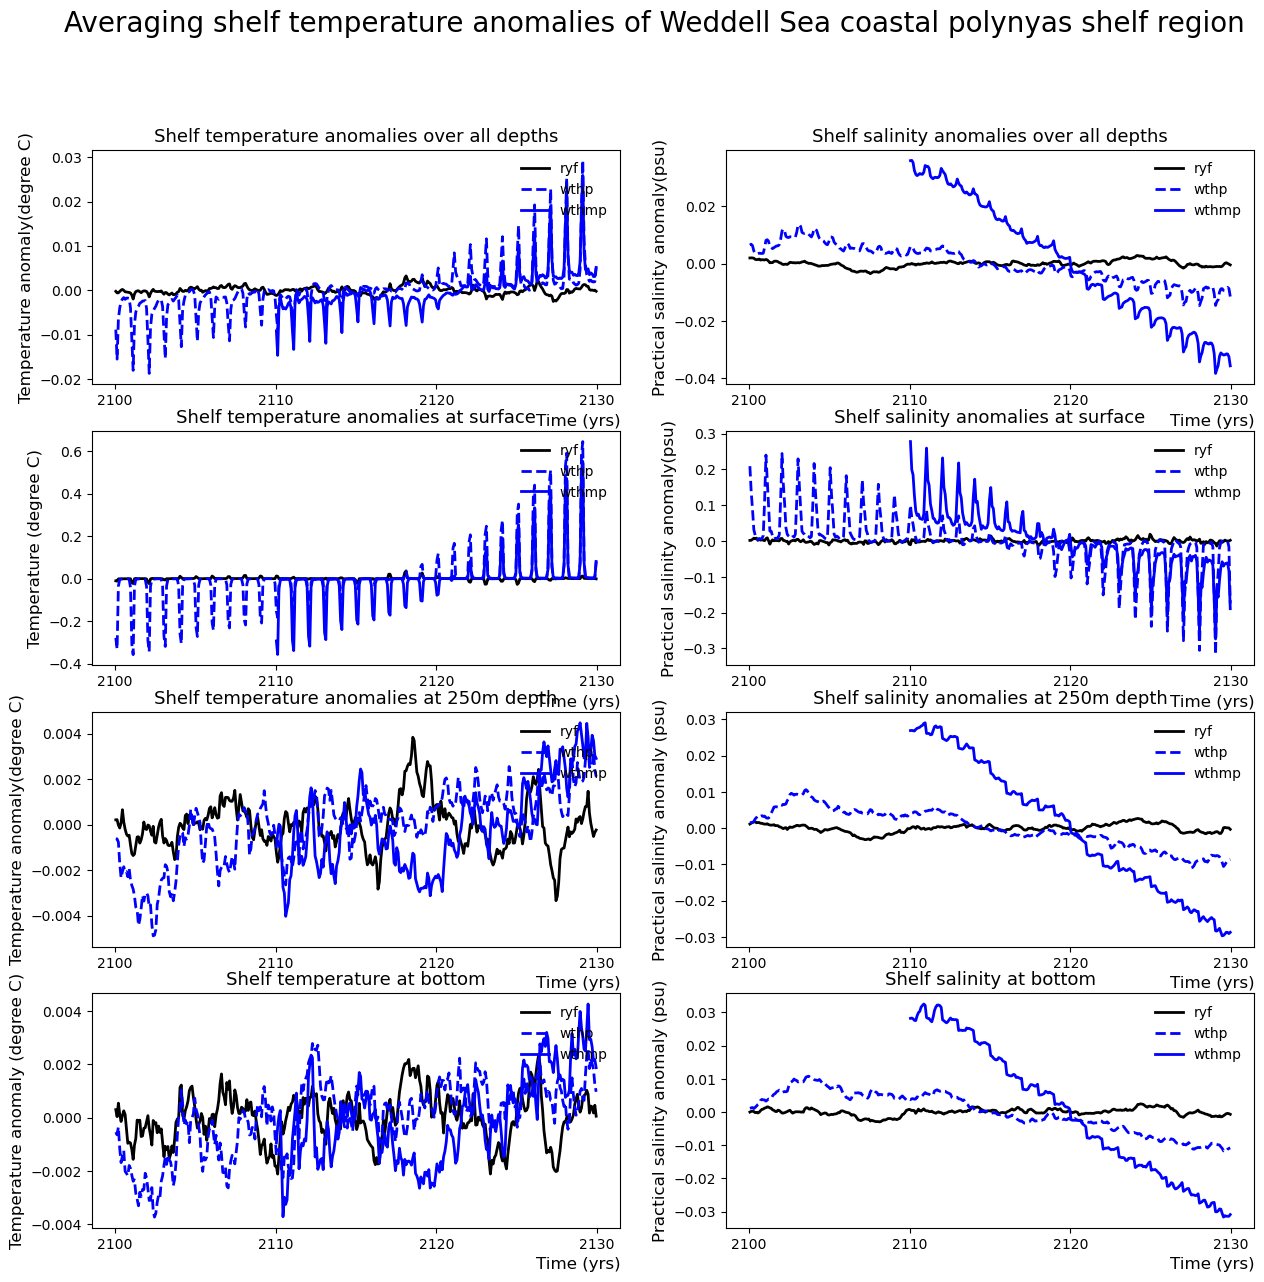

In [27]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature anomalies of Weddell Sea coastal polynyas shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

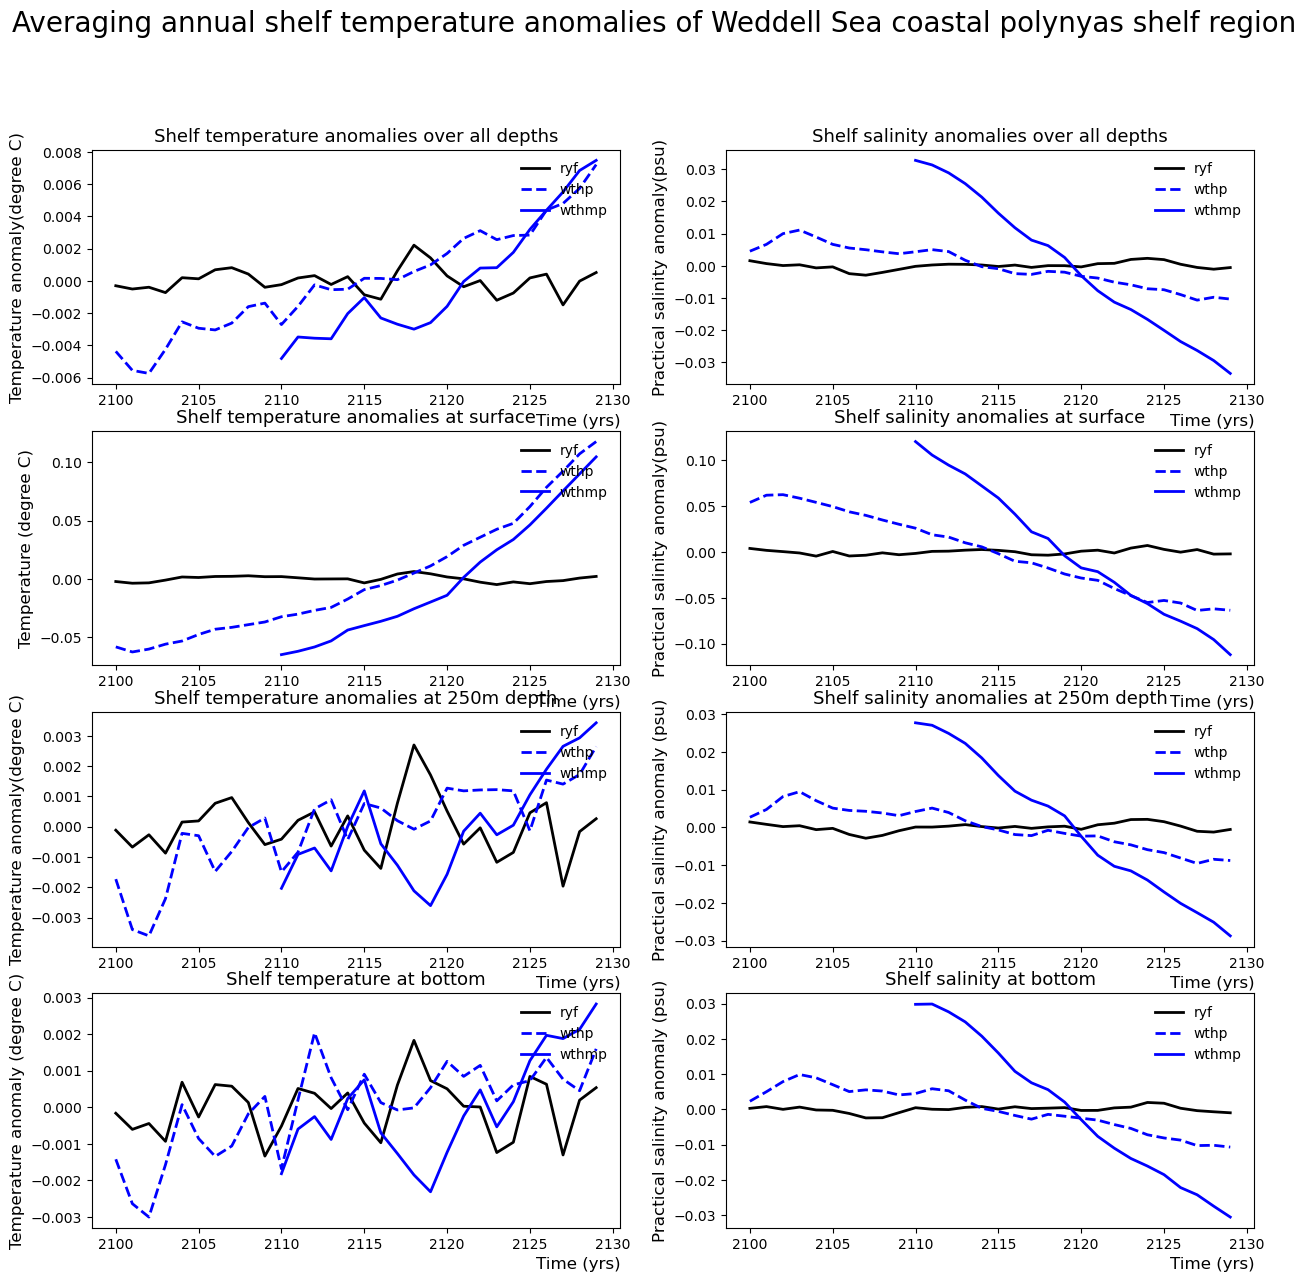

In [28]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature anomalies of Weddell Sea coastal polynyas shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

## Ross Sea coastal polynya shelf region

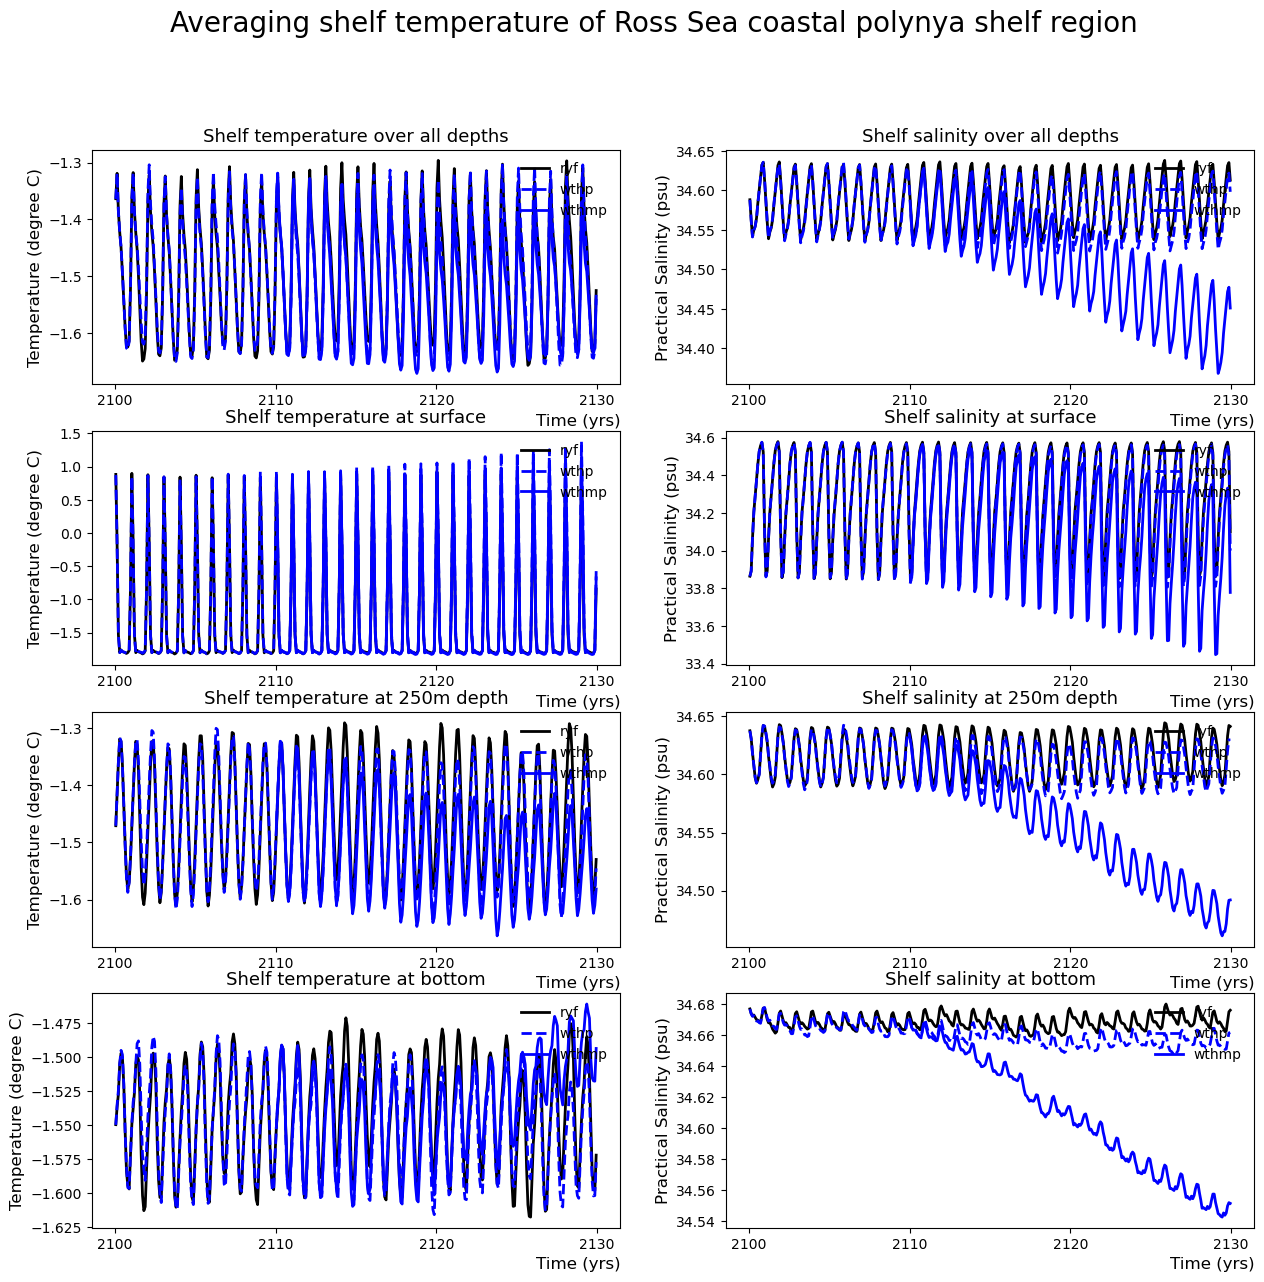

In [29]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature of Ross Sea coastal polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

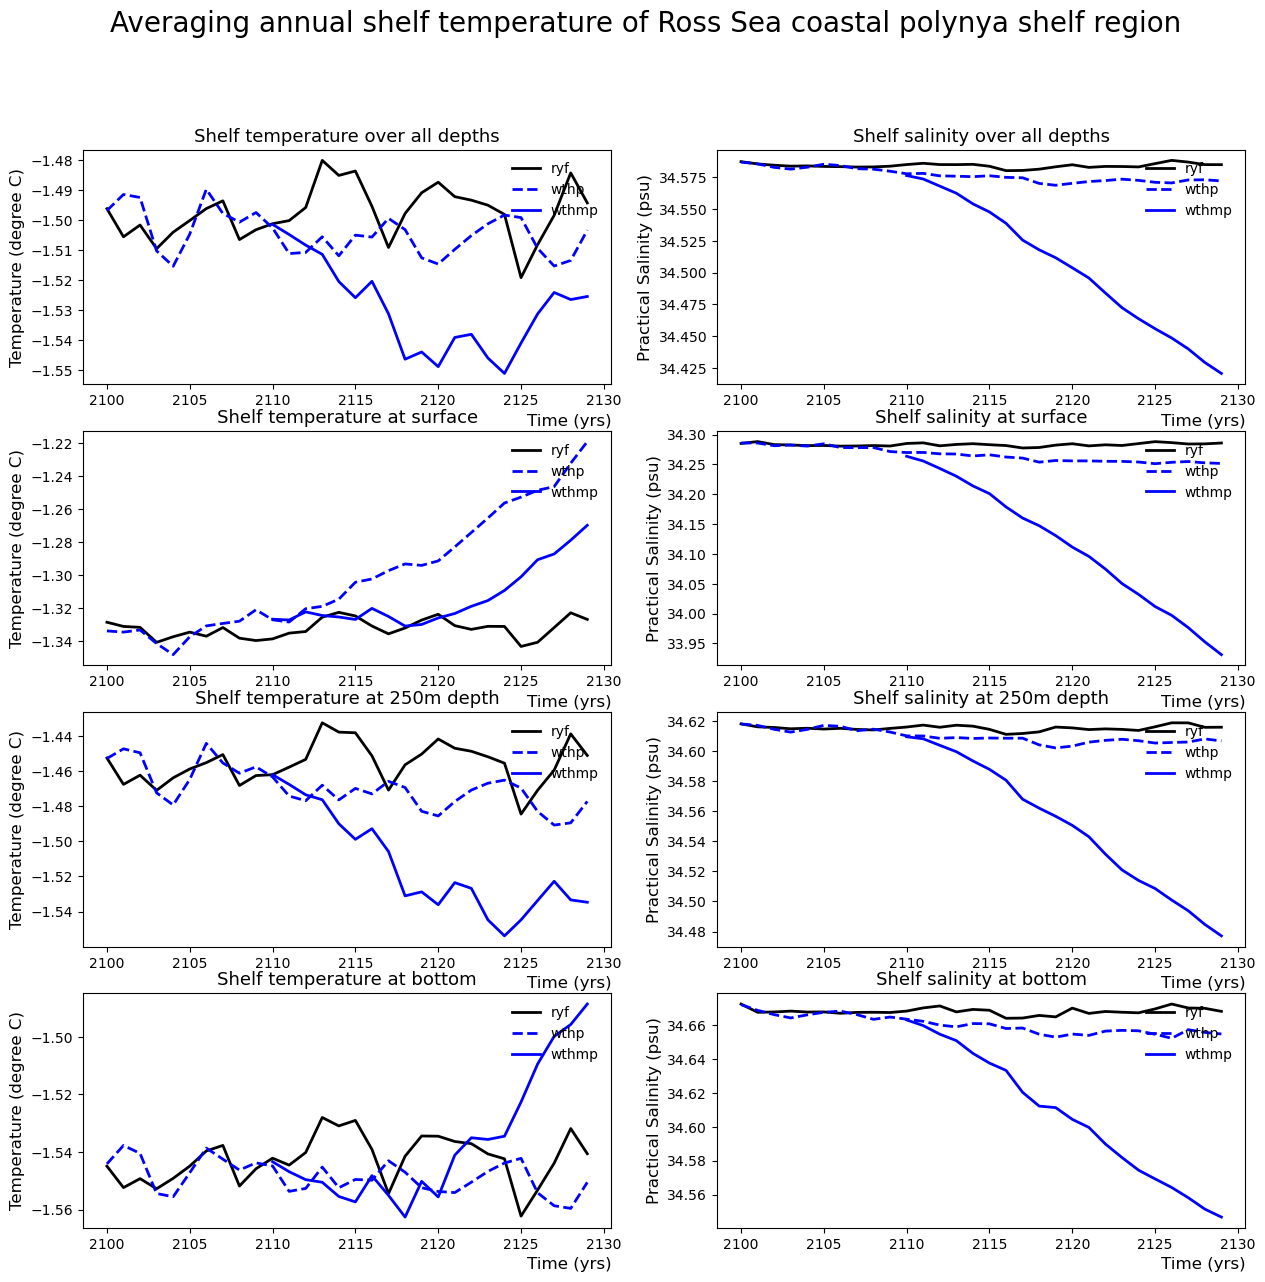

In [17]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature of Ross Sea coastal polynya shelf region', fontsize=20)

#Plotting annual mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

For Ross Sea region

T:
Wind, thermal and humidity perturbation experiment compared to the control ryf experiment shows a consistant cooling trend for surface temperature and little cooling changes over all depth, at 250m depth and bottom.

Wind, thermal, humidity and meltwater perturbation experiment compared to the wind, thermal and humidity perturbation experiment shows warmer waters averaging over all depth and surface and at 250m depth. T at bottom does not experience much change at the beginning but shows a consistant warming at the last 10 yrs.

S:
Wind, thermal and humidity perturbation experiment compared to the control ryf experiment shows a slightly consistant freshing trend.

Wind, thermal, humidity and meltwater perturbation experiment compared to the wind, thermal and humidity perturbation experiment shows consistant strong freshing trend.

## Cape Darnley polynya shelf region

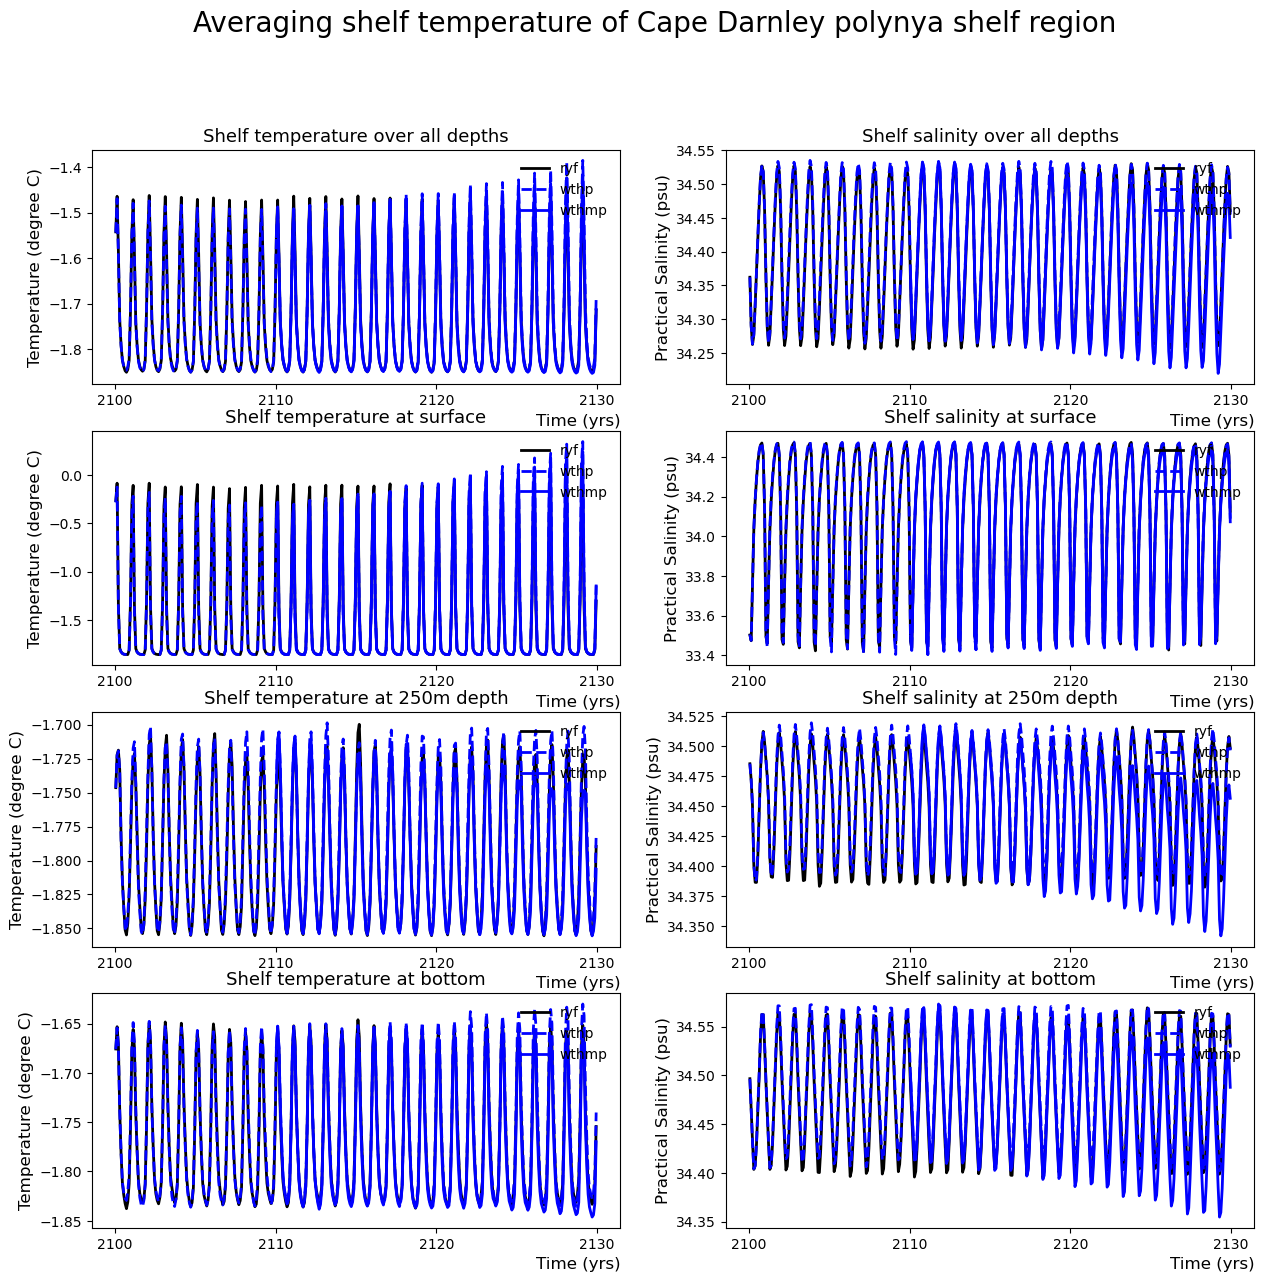

In [31]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature of Cape Darnley polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

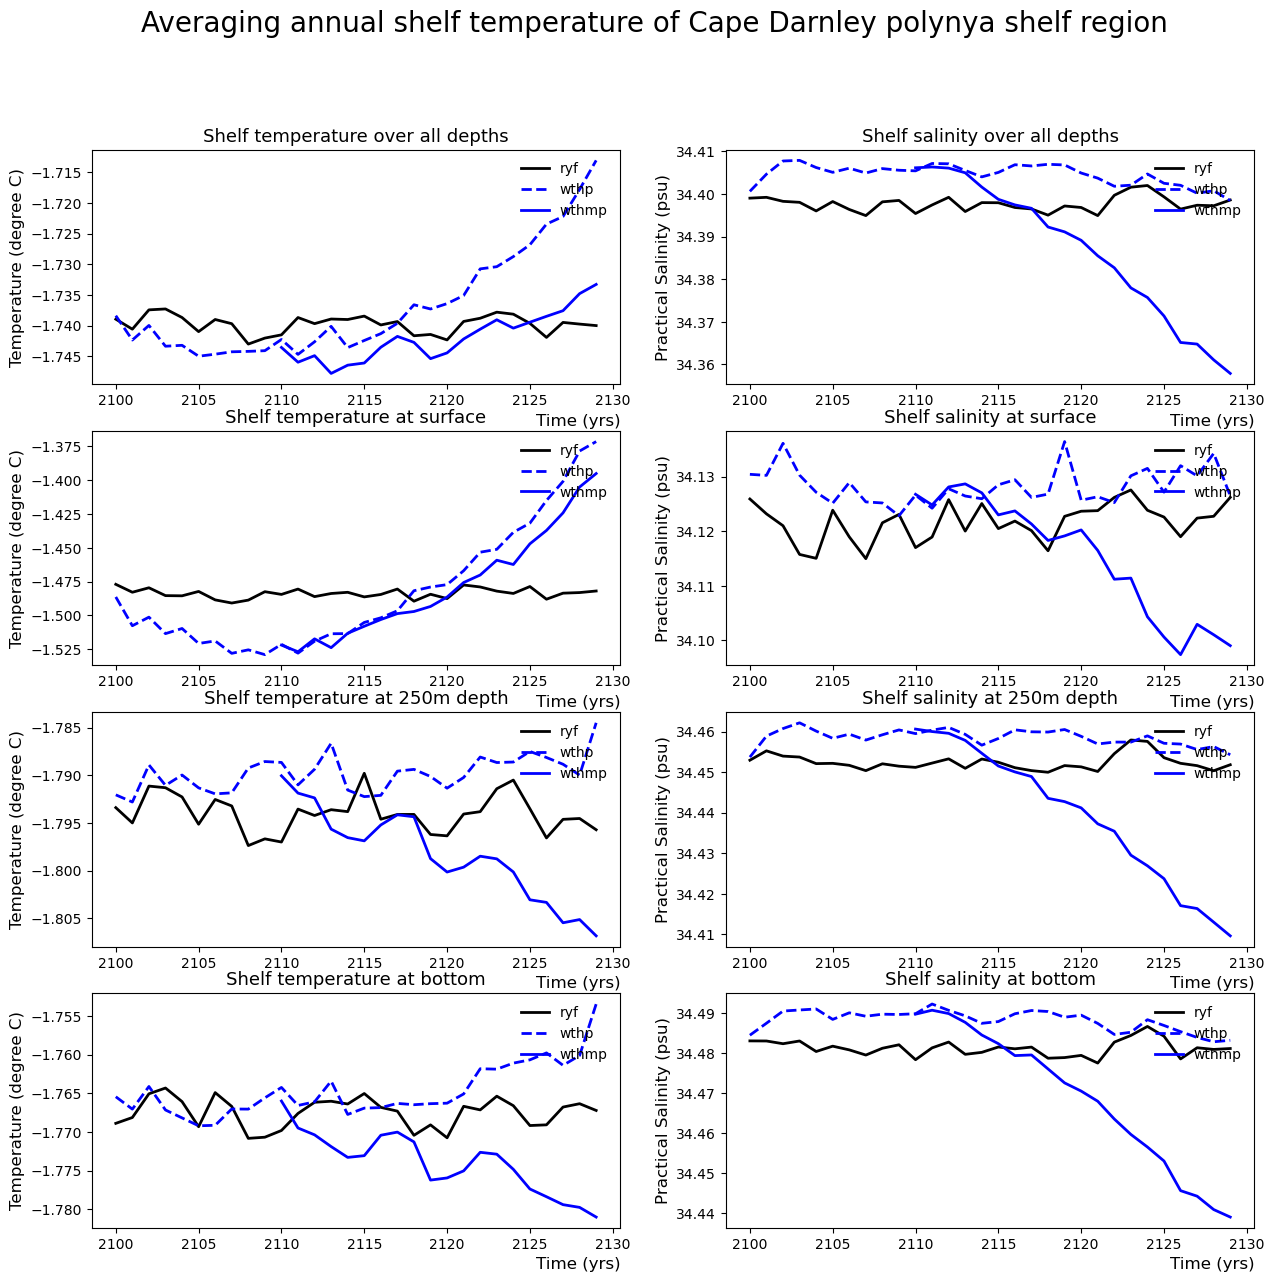

In [32]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature of Cape Darnley polynya shelf region', fontsize=20)

#Plotting annual mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

For Cape Darnley region

T:
Wind, thermal and humidity perturbation experiment compared to the control ryf experiment shows a cooling then consistant warming trend averaging over all depths and surface temperature and little warming shifts with fluctations at 250m depth and bottom, with a stronger shift at 250m depth.

Wind, thermal, humidity and meltwater perturbation experiment compared to the wind, thermal and humidity perturbation experiment shows less warming, with averaging over all depths being stronger. T at 250m depth and bottom instead experienced cooling response.

S:
Wind, thermal and humidity perturbation experiment compared to the control ryf experiment shows a slightly densing shifts.

Wind, thermal, humidity and meltwater perturbation experiment compared to the wind, thermal and humidity perturbation experiment shows consistant strong freshing trend.

## Mertz Glacier Polynya shelf region

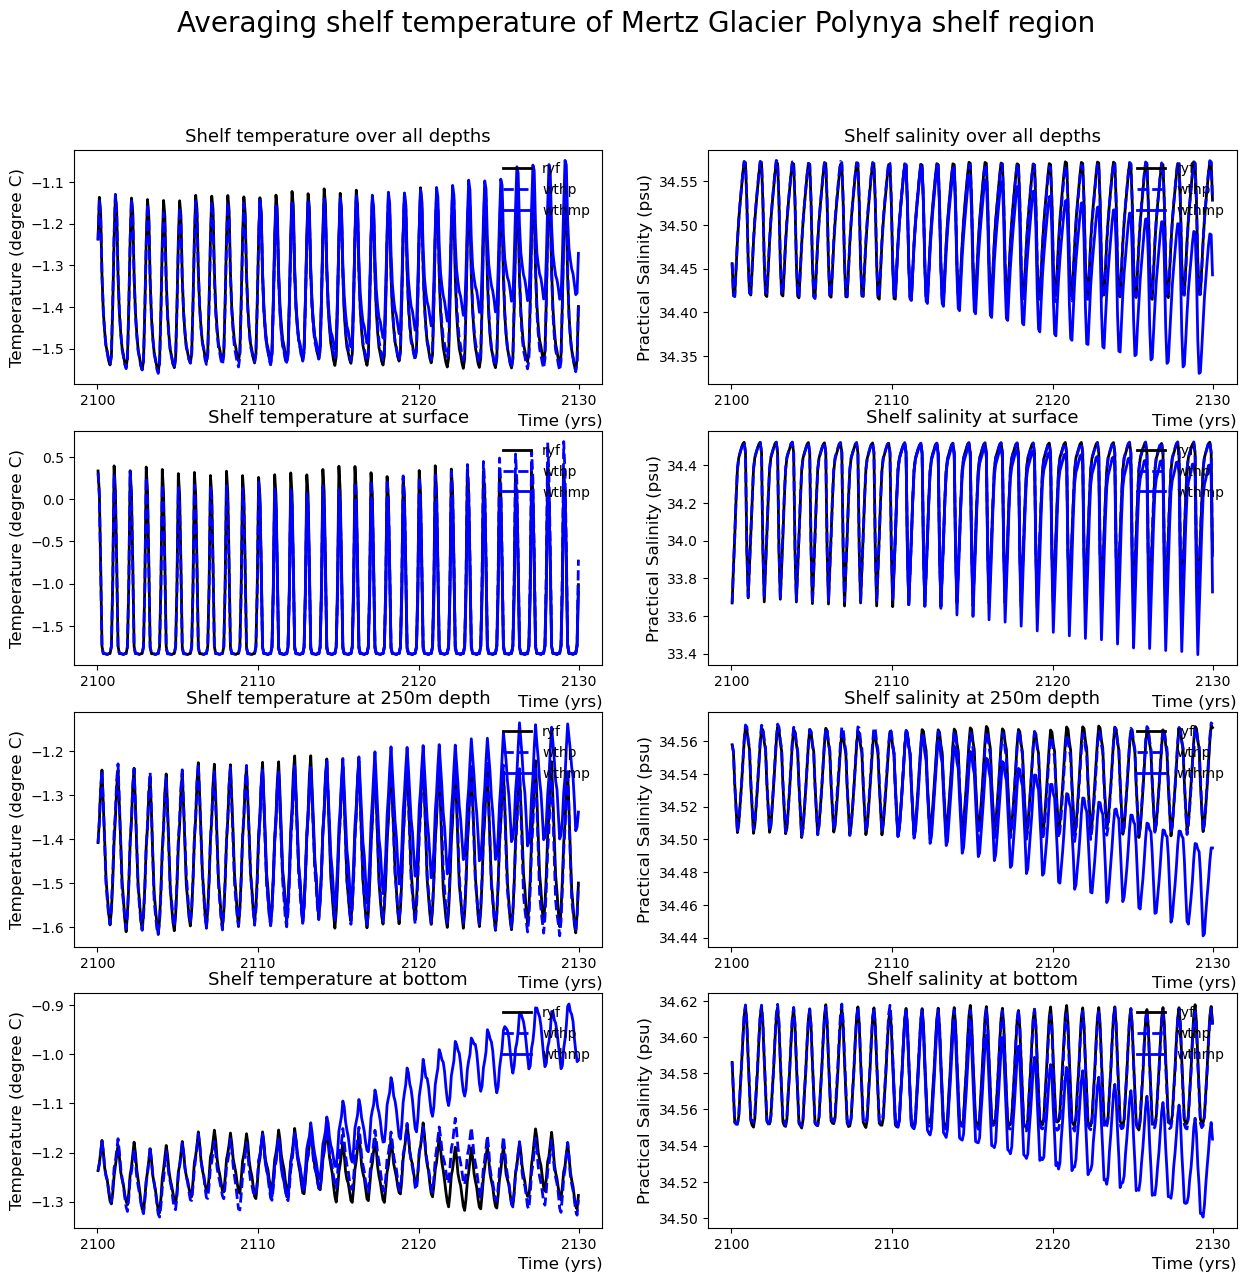

In [33]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature of Mertz Glacier Polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

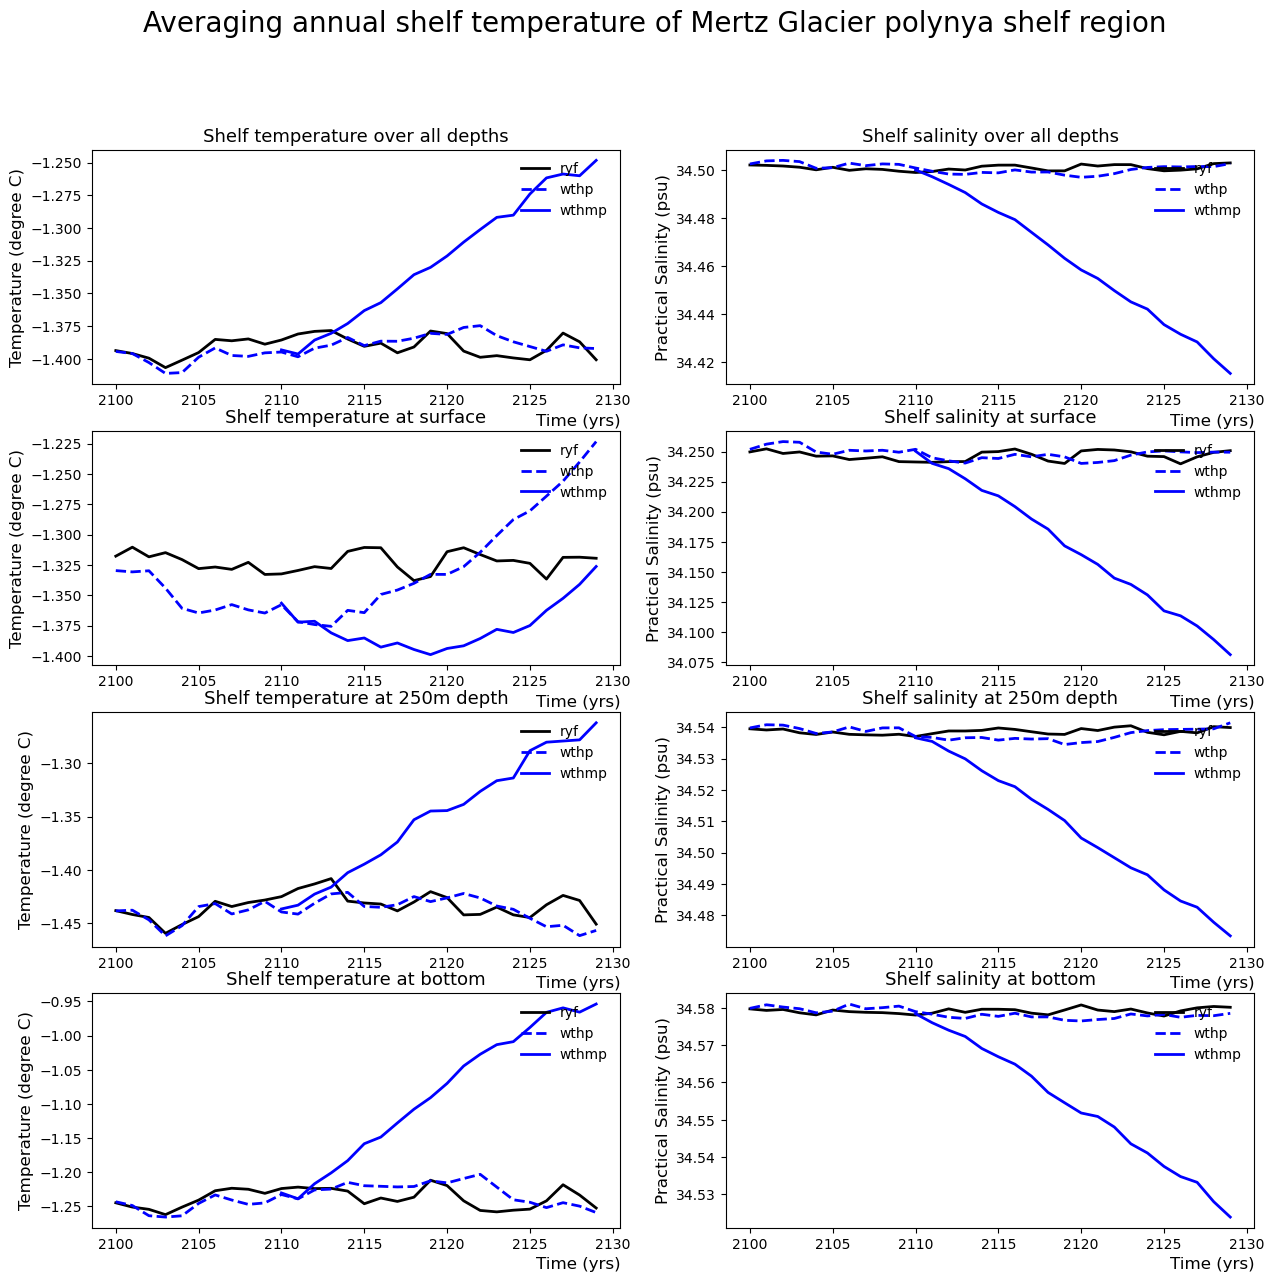

In [34]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature of Mertz Glacier polynya shelf region', fontsize=20)

#Plotting annual mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
salt_surface_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

For Mertz region

T:
Wind, thermal and humidity perturbation experiment compared to the control ryf experiment shows little flucations except for surface temperature, which experienced cooling then consistent warming responses.

Wind, thermal, humidity and meltwater perturbation experiment compared to the wind, thermal and humidity perturbation experiment shows stronger warming trend except for surface T, which did not following the warming trend when it begins to warm in wthp experiment but experience cooling then warming trend.

S:
Wind, thermal and humidity perturbation experiment compared to the control ryf experiment shows no shifts.

Wind, thermal, humidity and meltwater perturbation experiment compared to the wind, thermal and humidity perturbation experiment shows consistant strong freshing trend.